In [2]:
from math import log, sqrt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from datetime import datetime


In [3]:
#
VS = 4.99 #V
vout = 2.06 #V

DISTANCE = 0.165 * 2
VS0 = 331.45 #m/s

t0 = 298.15 # K
beta = 3950.0 #
R0 = 1e4 #Ohm
Rbalance = 9940

# Errore su vout e Vs? errore sulla resistenza di balance del partitore?
# sigma_vout = 1/100 * 1.75 # 1% divisione su scala verticale
sigma_vout = 1/100 # 1% divisione su scala verticale
sigma_Vs = 0.3 # misura tensione con AD2
sigma_Rb = 80 # misura con multimetro
sigma_d = 0.001 # sensibilita' metro a nastro


(14.250104526898724, 338.29499323410016, 0.24524879459601587, 2.255300463847112, 339.9858808846625, 1.8821)
(16.08062204340723, 340.03091190108194, 0.2458467577948915, 2.2668732523620276, 341.066886547272, 1.9851)
(18.66304970364871, 341.2545759136316, 0.2475475293203757, 2.275031010630015, 342.5861296467821, 2.1312)
(16.69668255974267, 341.3569455794276, 0.24616360405557072, 2.275713474917348, 341.4299291465083, 2.0199)
(19.664398391927136, 341.27575080665173, 0.24846376677829554, 1.3444204781721503, 343.1734138439354, 2.1879)
(20.09384162131721, 343.0745719365, 0.2488993512138398, 1.3515067387525486, 343.4249716648275, 2.2122)
(20.78372934185336, 343.1173773355376, 0.24965199716203165, 1.4556502681479941, 343.82870646372567, 2.2512)
(21.16450614458688, 343.1780366056572, 0.2500951095920253, 1.4559076103666966, 344.05134103939355, 2.2727)
Velocita' suono a temperatura ambiente: 330.49324464803715 $m/s$
error:  [0.21822598]
parametri ottimali= [330.49324465]
[[0.04762258]]
7.8540575255

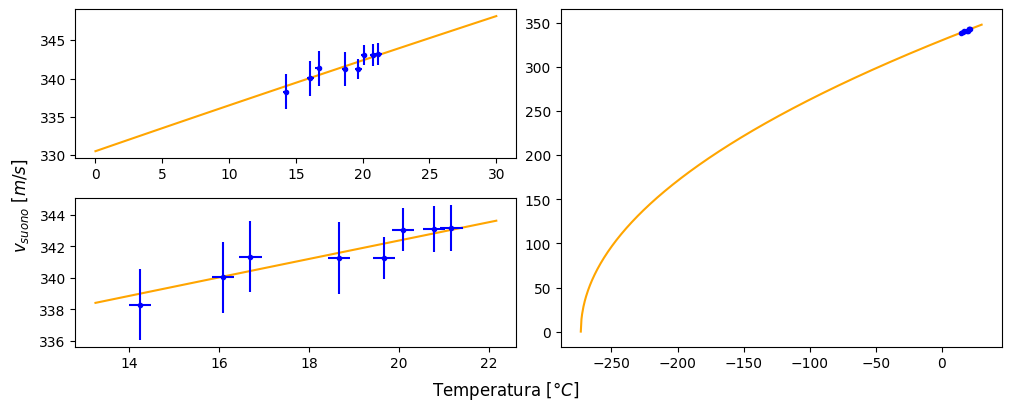

In [4]:
data = []
with open("very_final_data.csv","r") as f:
    f.readline()
    for l in f.readlines():
        if l.startswith("#") or l == "\n": continue
        _line = l.strip()
        _ = _line.split(",")
        vout = float(_[0])
        dt = float(_[1]) * 1e-3
        tf = float(_[2]) * 1e-3

        v_suono = DISTANCE / dt
        
        # _R = Rbalance * (vout/(VS-vout)) # termistore a massa NOSONAR
        _R = Rbalance * ((VS-vout)/vout) # termistore a +
        
        temp =  1/((1/t0) + (1/beta) * log(_R/R0)) - 273.15 # celsius NOSONAR
        # temp =  1/((1/t0) + (1/beta) * log(_R/R0)) # kelvin NOSONAR
        
        v_suono_aspettata = VS0 * sqrt((temp+273.15)/273.15)

        # Errore sulla resistenza del termistore
        sigma_R = (1/vout) * sqrt(
            (((Rbalance**2) * (VS**2) * (sigma_vout**2)) / (vout**2))
            + ((sigma_Vs**2)/(vout**2))
            + (((VS-vout)**2)*(sigma_Rb**2))
        )
        dt_dR = ((t0**2) * beta) / (_R * (beta + t0 * log(_R/R0))**2)

        # Errore sulla temperatura:
        sigma_T = dt_dR * sigma_R

        # Errore su dt?
        sigma_dt = 1/100 * tf # 1% della divisione sulla scala orizzontale

        # Errore sulla velocita' del suono?
        sigma_vs =sqrt((sigma_dt/dt)**2+(sigma_d/(2 * DISTANCE))**2)

        data.append((temp,v_suono, sigma_T, sigma_vs,v_suono_aspettata,vout))
        # data.append((time,vout,dt,tf,v_suono,temp,v_suono_aspettata))

for i in data:
    print(i)

# funzione di fit
def vs(x,vs0):
    return vs0*np.sqrt((x+273.15)/273.15)

_T = [x[0] for x in data]
sigma_T = [x[2] for x in data]
_vs = [x[1] for x in data]
sigma_vs = [x[3] for x in data]

popt,pcov=curve_fit(vs,_T,_vs, (331.45), sigma=sigma_vs, absolute_sigma=False)
x1 = np.linspace(_T[0]-1,_T[-1]+1,len(_T)*2)
x2 = np.linspace(0,30,30*2)
x3 = np.linspace(-273.15,30,304*2)
y_fit_L_1=vs(x1,popt[0])
y_fit_L_2=vs(x2,popt[0])
y_fit_L_3=vs(x3,popt[0])

fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gridspec = fig.add_gridspec(nrows=4, ncols=12)

axes = {}
axes['1'] = fig.add_subplot(gridspec[0:2, 0:6])
axes['2'] = fig.add_subplot(gridspec[2:4, 0:6])
axes['3'] = fig.add_subplot(gridspec[0:4, 6:12])

axes['1'].plot(x2, y_fit_L_2,color="orange",label="fit")
axes['1'].errorbar(_T, _vs,sigma_vs,sigma_T, linestyle = '', color = 'blue', marker = '.')
axes['2'].plot(x1, y_fit_L_1,color="orange",label="fit")
axes['2'].errorbar(_T, _vs,sigma_vs,sigma_T, linestyle = '', color = 'blue', marker = '.')

axes['3'].plot(x3, y_fit_L_3,color="orange",label="fit")
axes['3'].errorbar(_T, _vs,sigma_vs,sigma_T, linestyle = '', color = 'blue', marker = '.')

fig.supxlabel('Temperatura $[°C]$')
fig.supylabel('$v_{suono}$ $[m/s]$')

print(f"Velocita' suono a temperatura ambiente: {popt[0]} $m/s$")
err = np.sqrt(np.diag(pcov))
print("error: ", err)
# print(f"b: {popt[1]}")

# calculate the chisquare for the best-fit funtion
# note the indexing of the pars array elements
chi_2 = np.asarray([(((__vs-vs(__T,popt[0]))/sigma_vs)**2) for __T,__vs in zip(_T,_vs)]).sum()

# determine the ndof
ndof=len(_T)-len(popt)

print("parametri ottimali=", popt)
print(pcov)
print (chi_2, ndof)
chi2_ndof = chi_2/ndof # dev'essere circa 1
print(chi2_ndof)

plt.show()

Text(0.05, 0.95, '$v_{s0}=330.49[m/s]$\n$\\chi^2/ndof=1.12$')

<Figure size 640x480 with 0 Axes>

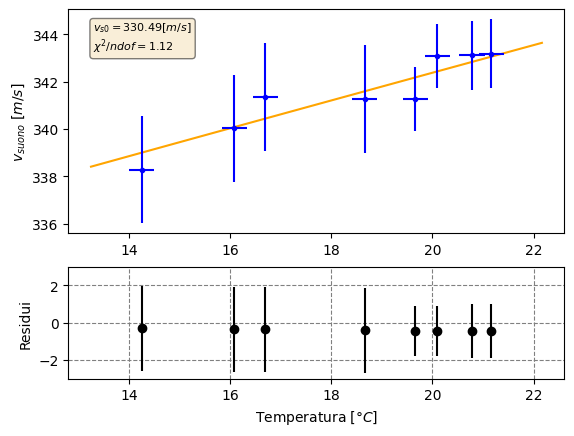

In [200]:
# GRAFICO DEI RESIDUI (normalizzati)
fig = plt.figure('Residui')
norm = np.asarray([x**2 for x in sigma_vs]).sum()
res = [(__vs - vs(__T, __vs)) / norm for __T,__vs in zip(_T,_vs)]

fig, ax = plt.subplots(2,1, height_ratios=[2, 1])

ax[1].errorbar(_T, res, sigma_vs, color='black', fmt='o')
ax[1].grid(which='both', ls='dashed', color='gray')
plt.xlabel('Temperatura $[°C]$')
ax[1].set_ylim(-3, 3)
ax[1].set_ylabel('Residui')
ax[0].set_ylabel('$v_{suono}$ $[m/s]$')
ax[1].sharex(ax[0])

ax[0].plot(x1, y_fit_L_1,color="orange",label="fit")
ax[0].errorbar(_T, _vs,sigma_vs,sigma_T, linestyle = '', color = 'blue', marker = '.')

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax[0].text(0.05, 0.95, '\n'.join((
    r'$v_{s0}=%.2f[m/s]$' % (popt[0]),
    r'$\chi^2/ndof=%.2f$' % (chi2_ndof),
)), transform=ax[0].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)